https://vene.ro/figurative-comparisons/#dataset

http://www.ep.liu.se/ecp/126/004/ecp16126004.pdf

https://www.aclweb.org/anthology/P13-3013

https://ansible.uk/misc/striking.html

in similes.txt, all phrases starting with 'Like' and 'As' were removed

Any old English, like "a flutter'd bird" were translated to modern spellings.

https://github.com/allenai/bilm-tf

http://www.english.su.se/polopoly_fs/1.100637.1347450592!/menu/standard/file/SMF_2012_Patrick_Hanks_plenary.pdf

https://www.academicscope.com/literature-review-on-automatic-simile-and-metaphor-recognizers/

McLachlan, G. J., & Rathnayake, S. (2014). On the number of components in a Gaussian mixture model. Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery, 4(5), 341-355.

http://aclweb.org/anthology/W18-09

Computational considerations of comparisons and similes
https://www.aclweb.org/anthology/P13-3013

A Computational System of Metaphor Generation with Evaluation Mechanism
https://rd.springer.com/content/pdf/10.1007%2F978-3-642-15822-3_18.pdf

Towards the Automatic Mining of Similes in Literary Texts
http://www.ep.liu.se/ecp/126/004/ecp16126004.pdf

Literature Review on Automatic Simile and Metaphor Recognizers
https://www.academicscope.com/literature-review-on-automatic-simile-and-metaphor-recognizers/

https://github.com/alexWhitworth/emclustr/blob/master/R/clust_mvn_miss.R

In [ ]:
import pandas as pd
import numpy as np

from itertools import permutations
from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.keyedvectors import KeyedVectors
import spacy

nlp = spacy.load('en_core_web_sm')

In [ ]:
from allennlp.commands.elmo import ElmoEmbedder
elmo = ElmoEmbedder()

# Simile data

Components are manually extracted

In [ ]:
component_ixs = [0,1,2,3]
component_tags = ['topic', 'event', 'ground', 'vehicle']

In [ ]:
sentences = pd.read_json('similes.json', orient='records')

%time sentences['nlp'] = sentences['original'].apply(lambda text: nlp(text))

len(sentences)

In [ ]:
model = KeyedVectors.load_word2vec_format('google-news.bin', binary=True)

In [ ]:
def embed_tokens(tokens):
    
#     elmo_v = elmo.embed_sentence(tokens)[1]

    w2v_v = np.ones((len(tokens), 300)) * np.nan
    for i, tk in enumerate(tokens):
        try:
            w2v_v[i, :] = model[tk]
        except:
            if tk not in OOV:
                OOV.append(tk)
    
    return w2v_v #np.hstack([elmo_v, w2v_v])

In [ ]:

OOV = []

# topic_vectors =   np.zeros((len(sentences), 300))
topic_vectors =   np.random.normal(scale=0.2, size=(len(sentences), 300))
# event_vectors =   np.zeros((len(sentences), 300))
event_vectors =   np.random.normal(scale=0.2, size=(len(sentences), 300))
# ground_vectors =  np.zeros((len(sentences), 300))
ground_vectors =  np.random.normal(scale=0.2, size=(len(sentences), 300))
# vehicle_vectors = np.zeros((len(sentences), 300))
vehicle_vectors = np.random.normal(scale=0.2, size=(len(sentences), 300))

for ix, s in sentences.iterrows():
    
    tokens = np.array([tk.text for tk in s['nlp']])
    embedding = embed_tokens(tokens)
        
    for tag, vec in zip(component_tags, [topic_vectors, event_vectors, ground_vectors, vehicle_vectors]):
        if s[tag]:
            emb = embedding[s[tag], :]
            
            if np.isnan(emb).all():
                print(ix, tag)
                mn = np.random.normal(scale=1, size=(300,))
            else:
                mn = np.nanmean(emb, axis=0)

            vec[ix] = mn

In [ ]:
print(OOV)

# Similarity with Latent Component

If we remove a component, the overall syntatical expression remains with a predictability that hopefully can be leveraged with a Gaussian Mixture Model (or some other latent variable maximization algorithm). 

In [ ]:
inp = {'original': 'Their love burned as passionate as', 'topic': [0,1], 'ground': [4], 'event': [2], 'vehicle': None}

tokens = np.array([tk.text for tk in nlp(inp['original'])])

example_topic_vector =   np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))
example_event_vector =   np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))
example_ground_vector =  np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))
example_vehicle_vector = np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))

embedding = embed_tokens(tokens)

if inp['topic']:
    example_topic_vector = embedding[inp['topic']].mean(axis=0)
if inp['event']:
    example_event_vector = embedding[inp['event']].mean(axis=0)
if inp['ground']:
    example_ground_vector = embedding[inp['ground']].mean(axis=0)
if inp['vehicle']:
    example_vehicle_vector = embedding[inp['vehicle']].mean(axis=0)


In [ ]:
yax_labs = ['', '', '', '']
xax_labs = ['', '', '', '']
ds = np.zeros((4,4))

comp = 14

norm = [topic_vectors[comp, :], event_vectors[comp, :], ground_vectors[comp, :], vehicle_vectors[comp, :]]
example = [example_topic_vector, example_event_vector, example_ground_vector, example_vehicle_vector]
labels = ['topic', 'event', 'ground', 'vehicle']

for i in range(4):
    e = sentences.loc[comp, [labels[i], 'original']].values
    phrase1 = np.array([tk.text for tk in nlp(e[1])])[e[0]]
    yax_labs[i] = ' '.join(phrase1)
    if inp[labels[i]]:
        d = 1 - pdist(np.vstack([norm[i], example[i]]), 'cosine')
    
        ds[i, i] = d
        
        e = sentences.loc[v2, [labels[i], 'original']].values
        
        phrase2 = np.array([tk.text for tk in nlp(inp['original'])])[inp[labels[i]]]
        xax_labs[i] = ' '.join(phrase2)
    elif inp[labels[i]] is None:
        xax_labs[i] = 'LAT'

g = sns.heatmap(ds, vmin=0, vmax=1, annot=True, cmap='copper')
g.set_xticklabels(xax_labs, rotation=30);
g.set_yticklabels(yax_labs, rotation=30);

# Dimension Reduction

In [ ]:
def get_component(simile_ix, comp):
    comp = sentences.loc[simile_ix, comp]
    return ' '.join([tk.text for i, tk in enumerate(sentences.loc[simile_ix, 'nlp']) if i in comp])

### PCA

In [ ]:
pca_comps = 50
dec = PCA(n_components=pca_comps)
decf = dec.fit_transform(ground_vectors)
    
plt.plot(list(range(pca_comps)), np.cumsum(dec.explained_variance_ratio_))
plt.xlabel('Component')
plt.ylabel('Variance Explained')
plt.grid(alpha=0.25)
plt.ylim([0,1]);

# GMM

In [ ]:
decomp_length = 4

decomp_topic = PCA(n_components=decomp_length)
decomp_event = PCA(n_components=decomp_length)
decomp_ground = PCA(n_components=decomp_length)
decomp_vehicle = PCA(n_components=decomp_length)

redu_array = np.array([topic_vectors, event_vectors, ground_vectors, vehicle_vectors])

redu_topic_vectors = decomp_topic.fit_transform(redu_array[0])
redu_event_vectors = decomp_event.fit_transform(redu_array[1])
redu_ground_vectors = decomp_ground.fit_transform(redu_array[2])
redu_vehicle_vectors = decomp_vehicle.fit_transform(redu_array[3])

redu_all = np.hstack([redu_topic_vectors, redu_event_vectors, redu_ground_vectors, redu_vehicle_vectors])

In [ ]:
redu_all.shape

In [ ]:
ns = [1]

growf = 1.2

while ns[-1] * growf < len(redu_all):
    
    ns.append(np.ceil(ns[-1] * growf).astype(int))

\# of components relies on the complexity of the input vectors

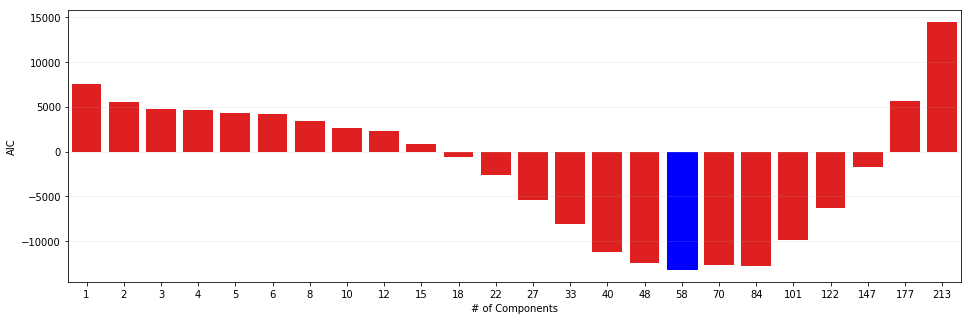

In [329]:
scores = []

m, n = redu_all.shape

# calculate some metric for GMM of n components
for n_comp in ns:
    gm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init=10, tol=1e-4)
    gmf = gm.fit(redu_all)
    
#     P = n_comp * (n + (n*(n+1))/2)

#     s = np.sum(gmf.score_samples(redu_all))
#     score = -1*s + 0.5 * P * np.log(m)
    
    scores.append(gmf.aic(redu_all))
    
plt.subplots(figsize=(16,5))
plt.ylabel('AIC')
plt.xlabel('# of Components')
plt.grid(alpha=0.2)
g = sns.barplot(ns, scores, color='r')

g.patches[np.argmin(scores)].set_color('b')

In [330]:
n_comps = ns[np.argmin(scores)]
gm = GaussianMixture(n_components=n_comps, covariance_type='full', n_init=10, tol=1e-4)

%time gmf = gm.fit(redu_all)

gm

CPU times: user 1.01 s, sys: 21.2 ms, total: 1.03 s
Wall time: 607 ms


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=58, n_init=10, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.0001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
p = gmf.predict(redu_all)

np.unique(p, return_counts=True)

In [ ]:
sentences.loc[p == 3, 'original']

# Generative Model

In [ ]:
def cycle_latent_data(input_dict):
    global component_ixs

    tv = np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))
    ev = np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))
    gv = np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))
    vv = np.zeros((1, 300)) #.random.normal(scale=0.5, size=(1, 300))

    embedding = embed_tokens(input_dict['tokens'])
    
    latent = []

    if inp['topic']:
        tv = embedding[inp['topic']].mean(axis=0)
    else:
        latent.append('topic')

    if inp['event']:
        ev = embedding[inp['event']].mean(axis=0)
    else:
        latent.append('event')

    if inp['ground']:
        gv = embedding[inp['ground']].mean(axis=0)
    else:
        latent.append('ground')

    if inp['vehicle']:
        vv = embedding[inp['vehicle']].mean(axis=0)
    else:
        latent.append('vehicle')   
        
    out = []
    
    for mix in permutations(latent):
        combined = np.array([tv, ev, gv, vv])
        mixout = []
        for lat in mix:
            ix = component_tags.index(lat)
            del component_ixs[ix]
            latent, vocab_ix, comp, post_prob = cycle_potential_vocab(lat, combined[component_ixs])
            mixout.append([ix, vocab_ix, comp, post_prob])
            combined[ix] = redu_array[ix, vocab_ix]
            component_ixs = [0,1,2,3]
            
        out.append(mixout)
        
    return np.array(out)

def cycle_potential_vocab(latent_component, remaining_components):
    '''
    Given an unknown vector, but three known vectors, iterate over all vocabularly possibilities to
    maximize the posterior.
    
    i.e. choose the best vocab for the missing data
    '''
    if latent_component is 'topic':
        posteriors = np.zeros((len(topic_vectors), 2))
        for i, vec in enumerate(topic_vectors):
            posteriors[i, :] = choose_best_mixture(gmf, vec, remaining_components[0], remaining_components[1], remaining_components[2])
    
    elif latent_component is 'event':
        posteriors = np.zeros((len(event_vectors), 2))
        for i, vec in enumerate(event_vectors):
            posteriors[i, :] = choose_best_mixture(gmf, remaining_components[0], vec, remaining_components[1], remaining_components[2])
    
    elif latent_component is 'ground':
        posteriors = np.zeros((len(ground_vectors), 2))
        for i, vec in enumerate(ground_vectors):
            posteriors[i, :] = choose_best_mixture(gmf, remaining_components[0], remaining_components[1], vec, remaining_components[2])
    
    elif latent_component is 'vehicle':
        posteriors = np.zeros((len(vehicle_vectors), 2))
        for i, vec in enumerate(vehicle_vectors):
            posteriors[i, :] = choose_best_mixture(gmf, remaining_components[0], remaining_components[1], remaining_components[2], vec)
    
    m = np.argmax(posteriors[:, 1])
    return latent_component, m, posteriors[m, 0], posteriors[m, 1]
    
def choose_best_mixture(gmm, topic, event, ground, vehicle):
    '''
    Given four vector components, return the MAP estimate of which Gaussian component the vectors should
    belong to.
    
    i.e. choose the best model for and probability of the given data
    '''
    redu_topic = decomp_topic.transform(np.atleast_2d(topic))
    redu_event = decomp_event.transform(np.atleast_2d(event))
    redu_ground = decomp_ground.transform(np.atleast_2d(ground))
    redu_vehicle = decomp_vehicle.transform(np.atleast_2d(vehicle))
    
    redu_all = np.hstack([redu_topic, redu_event, redu_ground, redu_vehicle])
    
    posteriors = np.zeros(n_comps)
    
    for gmm_comp in range(n_comps):
        mean = gmm.means_[gmm_comp, :]
        cov = gmm.covariances_[gmm_comp, :, :]
        
        rv = multivariate_normal(mean=mean, cov=cov)
                
        posteriors[gmm_comp] = rv.logpdf(redu_all) 
                        
    return (np.argmax(posteriors), np.max(posteriors))

In [ ]:
def piece_fit(fit):
    complete = {}
    for comp_ix in component_ixs:
        tag = component_tags[comp_ix]

        if comp_ix in fit[:, 0].astype(int):
            w = np.where(fit[:, 0].astype(int) == comp_ix)[0]
            text = get_component(int(fit[w, 1]), tag)
            complete[tag] = text
        else:
            complete[tag] = " ".join(inp["tokens"][inp[tag]])

    return complete

def format_simile(components):
    t = components['topic']
    e = components['event']
    g = components['ground']
    v = components['vehicle']
    if g and t and e and v:
        return f'{t} {e} as {g} as {v}'
    elif not g and t and e and v:
        return f'{t} {e} like {v}'
    elif not t and g and not e and v:
        return f'{g} like {v}'
    elif not e and t and g and v:
        return f'{t} as {g} as {v}'
    else:
        return components

In [332]:
inp = {'original': 'My mind', 'topic': [0,1], 'ground': None, 'event': None, 'vehicle': None}
inp['tokens'] = np.array([tk.text for tk in nlp(inp['original'])])

z = cycle_latent_data(inp)

best_fit = np.argmax(np.sum(z[:, :, 3], axis=1))

format_simile(piece_fit(z[best_fit]))

'My mind clatters like a wave of the wild sea'